In [22]:
import os

from dtscalibration import read_silixa_files
import matplotlib.pyplot as plt
import warnings

from dtscalibration import read_silixa_files

from dtscalibration.datastore_utils import suggest_cable_shift_double_ended, shift_double_ended
import numpy as np
import scipy.stats as st 
from scipy import signal
import scipy
%matplotlib notebook


warnings.simplefilter("ignore")  # Hide warnings to avoid clutter in the notebook

In [23]:
filepath1 = 'Antarctica_lastYear/'
filepath2 = 'Antarctica_5min/'

ds_1 = read_silixa_files(
    directory=filepath1,
    timezone_netcdf='UTC',
    file_ext='*.xml')

ds_2 = read_silixa_files(
    directory=filepath2,
    timezone_netcdf='UTC',
    file_ext='*.xml')

ds1 = ds_1.sel(x=slice(-27,650.8))# only calibrate parts of the fiber
ds2 = ds_2.sel(x=slice(-27,650.8))# only calibrate parts of the fiber

3 files were found, each representing a single timestep
6 recorded vars were found: LAF, ST, AST, REV-ST, REV-AST, TMP
Recorded at 3553 points along the cable
The measurement is double ended
Reading the data from disk
64 files were found, each representing a single timestep
6 recorded vars were found: LAF, ST, AST, REV-ST, REV-AST, TMP
Recorded at 3537 points along the cable
The measurement is double ended
Reading the data from disk


<IPython.core.display.Javascript object>


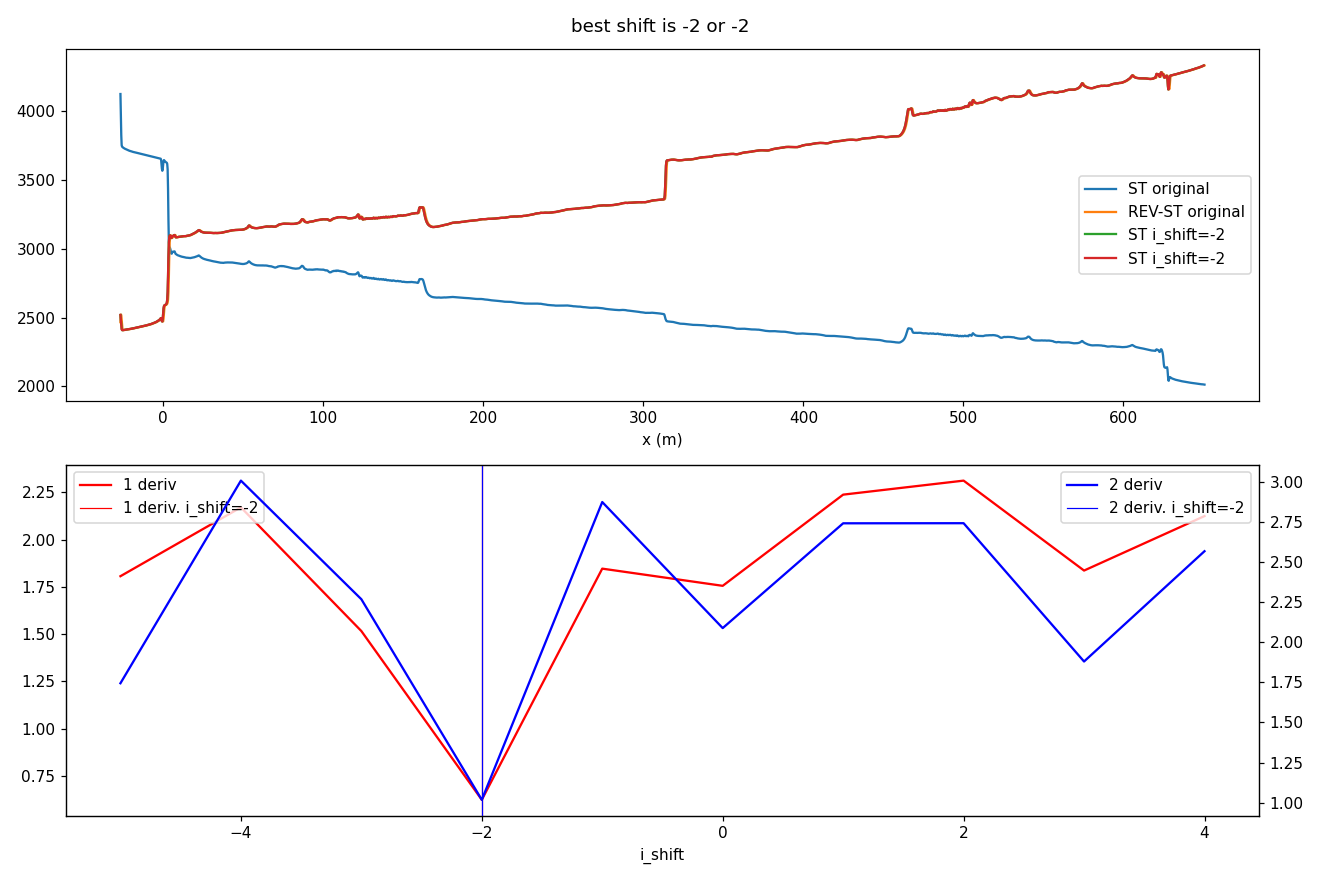

I dont know what to do with the following data ['tmp']
I dont know what to do with the following data ['tmp']
I dont know what to do with the following data ['tmp']


<IPython.core.display.Javascript object>


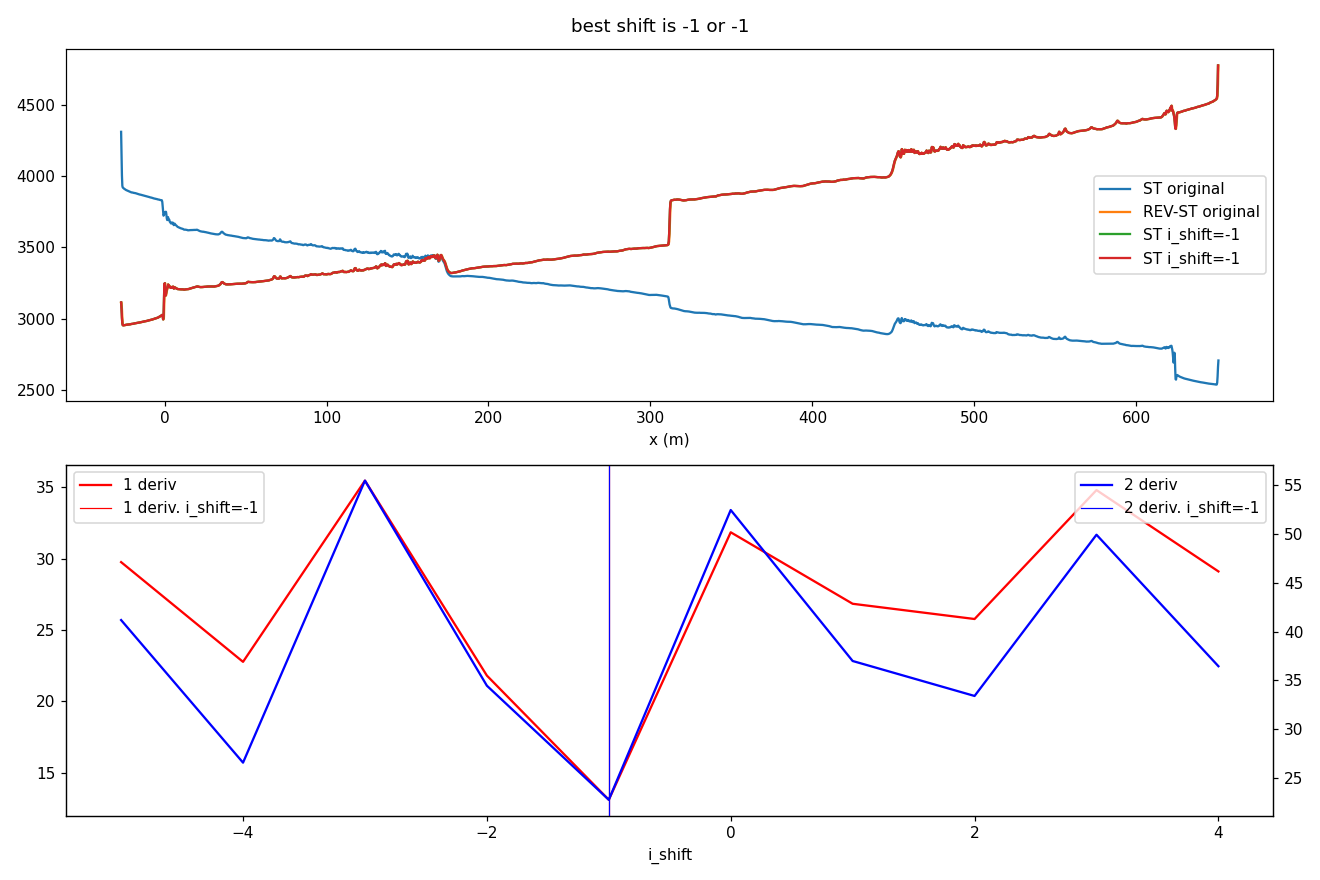

I dont know what to do with the following data ['tmp']
I dont know what to do with the following data ['tmp']
I dont know what to do with the following data ['tmp']
<xarray.DataArray 'x' (x: 2666)>
array([-26.812, -26.558, -26.303, ..., 650.121, 650.375, 650.629])
Coordinates:
  * x        (x) float64 -26.81 -26.56 -26.3 -26.05 ... 649.9 650.1 650.4 650.6
Attributes:
    name:              distance
    description:       Length along fiber
    long_description:  Starting at connector of forward channel
    units:             m 


 <xarray.DataArray 'x' (x: 2664)>
array([-26.812, -26.558, -26.303, ..., 649.613, 649.867, 650.121])
Coordinates:
  * x        (x) float64 -26.81 -26.56 -26.3 -26.05 ... 649.4 649.6 649.9 650.1
Attributes:
    name:              distance
    description:       Length along fiber
    long_description:  Starting at connector of forward channel
    units:             m
<xarray.DataArray 'x' (x: 2666)>
array([-26.812, -26.558, -26.303, ..., 650.121, 650.375, 650.6

In [24]:
suggested_shift1 = suggest_cable_shift_double_ended(
    ds1,
    np.arange(-5, 5),
    plot_result=True,
    figsize=(12,8))

ds_restored1 = shift_double_ended(ds1, suggested_shift1[0])

suggested_shift = suggest_cable_shift_double_ended(
    ds2,
    np.arange(-5, 5),
    plot_result=True,
    figsize=(12,8))

ds_restored2 = shift_double_ended(ds2, suggested_shift[0])

print(ds1.x, 3*'\n', ds_restored1.x)
print(ds2.x, 3*'\n', ds_restored2.x)


In [29]:
ds1 = ds_restored1
ds2 = ds_restored2

In [38]:

### Sections for 2022 deployment ###
matching_sections1 = [
    (slice(130., 158.), slice(470.5, 498.75), False)
]
sections1 = {
    'probe1Temperature': [slice(130., 158.), slice(470., 500.)]
    }

### Sections for 2023 deployment ###
sections2 = {
    "referenceTemperature": [slice(-23, -3), slice(628.5, 647.5)], 
}

matching_sections2 = [(slice(-26.7, 311.9), slice(311.9, 650.8), True)]

ds1.sections = sections1
ds2.sections = sections2

<IPython.core.display.Javascript object>


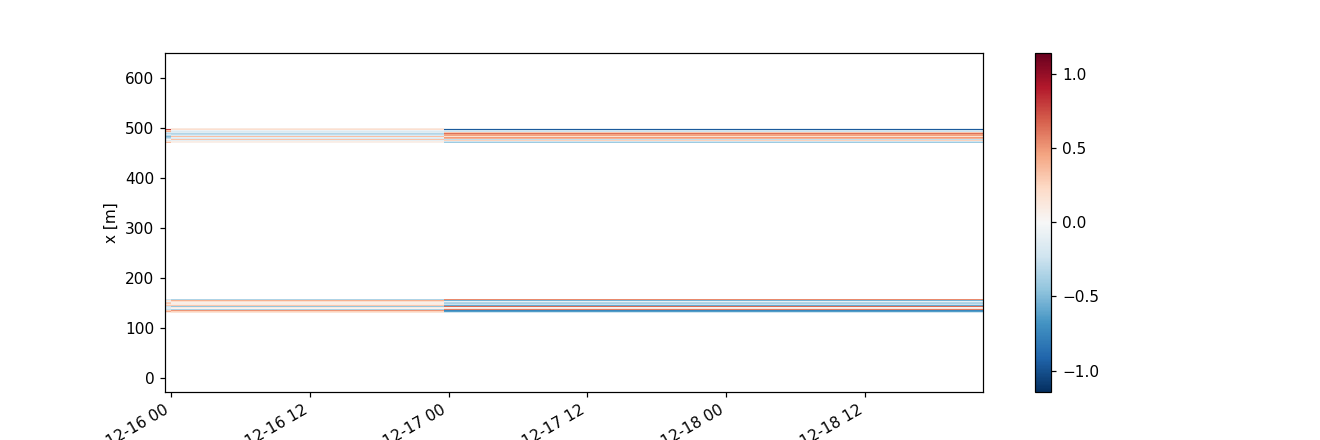

<IPython.core.display.Javascript object>


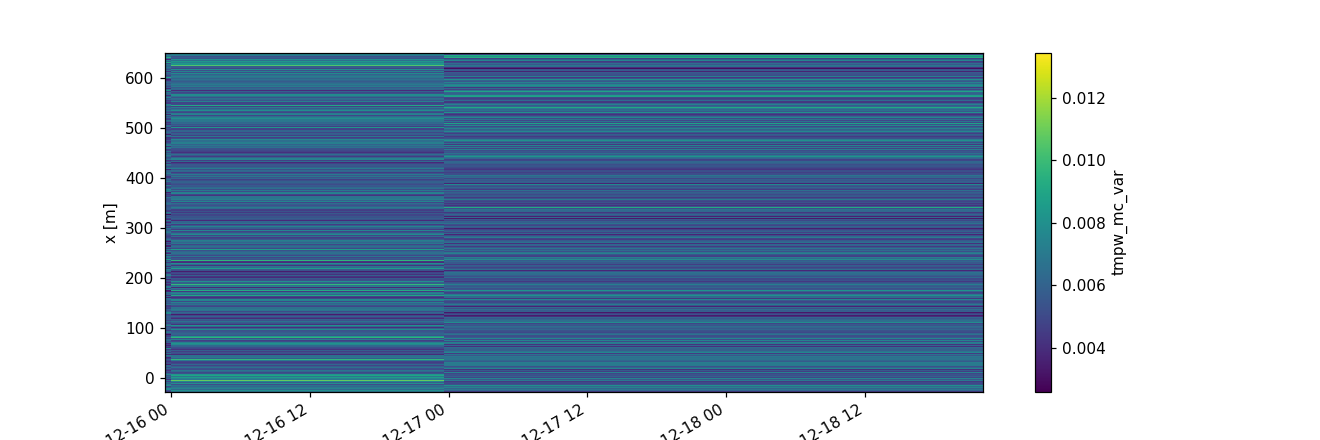

<IPython.core.display.Javascript object>


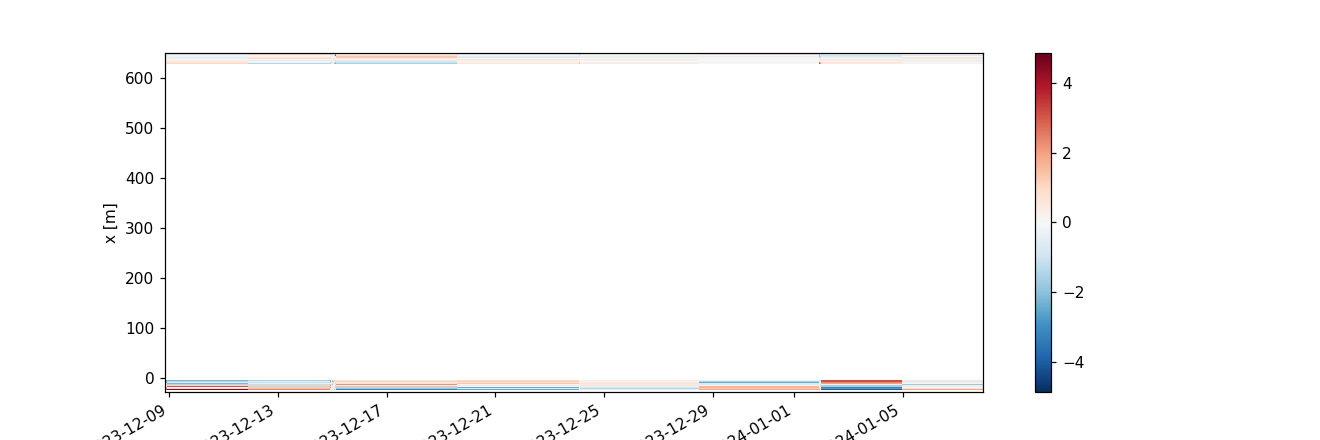

<IPython.core.display.Javascript object>


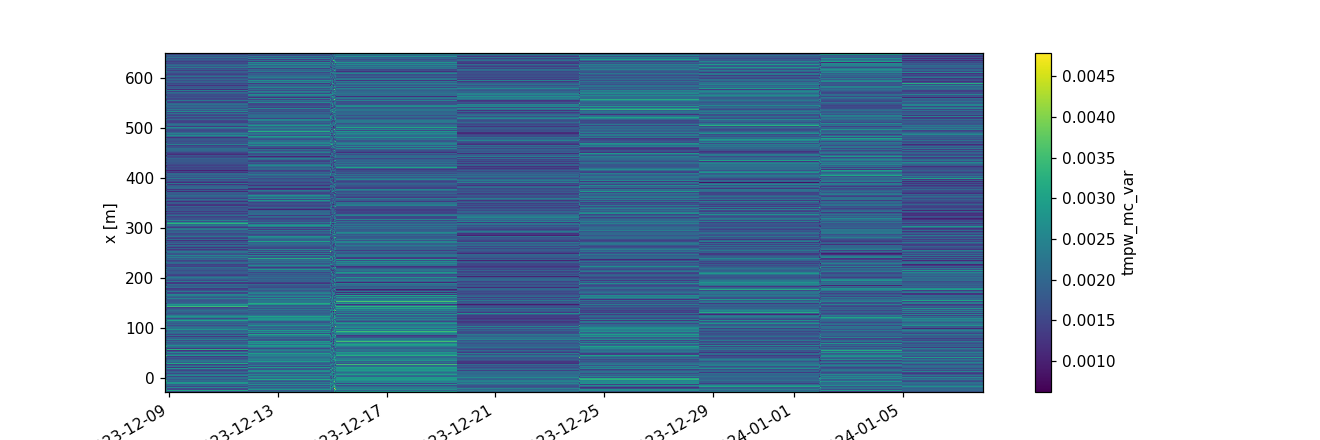

In [48]:
st_var, resid = ds1.variance_stokes(st_label='st')
ast_var, _ = ds1.variance_stokes(st_label='ast')
rst_var, _ = ds1.variance_stokes(st_label='rst')
rast_var, _ = ds1.variance_stokes(st_label='rast')

ds1.calibration_double_ended(
    st_var=st_var,
    ast_var=ast_var,
    rst_var=rst_var,
    rast_var=rast_var,
    matching_sections=matching_sections1,
    store_tmpw='tmpw',
    method='wls',
    solver='sparse')

resid.plot(figsize=(12, 4))
ds1.tmpw_mc_var.plot(figsize=(12, 4))

st_var, resid = ds2.variance_stokes(st_label='st')
ast_var, _ = ds2.variance_stokes(st_label='ast')
rst_var, _ = ds2.variance_stokes(st_label='rst')
rast_var, _ = ds2.variance_stokes(st_label='rast')

ds2.calibration_double_ended(
    st_var=st_var,
    ast_var=ast_var,
    rst_var=rst_var,
    rast_var=rast_var,
    matching_sections=matching_sections2,
    store_tmpw='tmpw',
    method='wls',
    solver='sparse')

resid.plot(figsize=(12, 4))
ds2.tmpw_mc_var.plot(figsize=(12, 4))

In [41]:
### Cell for grouping boreholes and figuring which is which ###
data = {}
holder1 = []
holder2 = []
holder3 = []
holder4 = []
holder5 = []
holder6 = []
for i in range(len(ds2.time)):
    if i < 11:
        holder1.append(ds2.isel(time=i))
    if 11 <= i < 42:
        holder2.append(ds2.isel(time=i))
        
    if 43 <= i < 49:
        holder3.append(ds2.isel(time=i))
        
    if 49 <= i < 62:
        holder4.append(ds2.isel(time=i))
        
    if i >= 62:
        holder5.append(ds2.isel(time=i))
for i in range(len(ds1.time)):
    holder6.append(ds1.isel(time=i))
    
data['ALHIC1901_23'] = holder1
data['ALHIC1903'] = holder2
data['ALHIC1902'] = holder3
data['New_Eclipse'] = holder4
data['ALHIC2201'] = holder5
data['ALHIC1901_22'] = holder6


In [42]:
### 1901 borehole geometry ###
top_of_borehole = 170.6 #m
top_of_trend = 190 #m
bottom_of_trend = 310 #m, this is the last depth measurement we want to keep
below_noise = 190 #m, this shoiuld be below the noisy part of the data (maybe due to cable strain?
bottom_hole = 311.9 #m, this is the bottom of the hole

refl_corr = 2*(bottom_hole - bottom_of_trend) + bottom_of_trend
top_refl = refl_corr + (bottom_of_trend-below_noise)
sample_steps = 0.255 #m

In [187]:
## Plotting the anomaly for all boreholes ###


below_seasons = [180, 184, 124, 242, 240, 180]
# below_seasons = [170.6, 164, 104, 222, 220]
sos = signal.butter(4, .06, 'hp', fs=4, output='sos')

calc_dict = {}

for name, start in zip(data, below_seasons):
    borehole_data = data[name]

    borehole_arr = np.zeros((len(borehole_data[0].sel(x=slice(start,bottom_of_trend)).tmpw.T),
                                     len(borehole_data)*2))
    refl_corr = 2*(bottom_hole - bottom_of_trend) + bottom_of_trend
    top_refl = refl_corr + (bottom_of_trend-start)
    sample_steps = 0.255 #m
    print(borehole_arr.shape)
    for j in range(int(borehole_arr.shape[1]/2)):
        measurement_for = borehole_data[j].sel(x=slice(start,bottom_of_trend)).tmpw.T
        measurement_rev = borehole_data[j].sel(x=slice(refl_corr, top_refl)).tmpw[::-1]
        if len(measurement_rev) != len(measurement_for):
            measurement_rev = borehole_data[j].sel(x=slice(refl_corr, top_refl - sample_steps)).tmpw[::-1]
        detrend_for = scipy.signal.detrend(measurement_for, type='linear', bp=0, overwrite_data=False)
        detrend_rev = scipy.signal.detrend(measurement_rev, type='linear', bp=0, overwrite_data=False)

        filtered_for = signal.sosfilt(sos, detrend_for)
        filtered_rev = signal.sosfilt(sos, detrend_rev)

        borehole_arr[:,j] = filtered_for
        borehole_arr[:,int(borehole_arr.shape[1]/2)+j] = filtered_rev
    
    mean = np.mean(borehole_arr, axis=1)
    ci95, ci05 = st.t.interval(alpha=0.95, df=len(borehole_arr)-1, 
                  loc=mean, 
                  scale=st.sem(borehole_arr, axis=1)) 
    arr_std = np.std(borehole_arr,axis=1)
    x = borehole_data[0].sel(x=slice(start,bottom_of_trend)).x
    calc_dict[name] = x, mean, arr_std, ci95, ci05

(511, 22)
(495, 62)
(731, 12)
(267, 26)
(275, 4)
(511, 6)


<IPython.core.display.Javascript object>


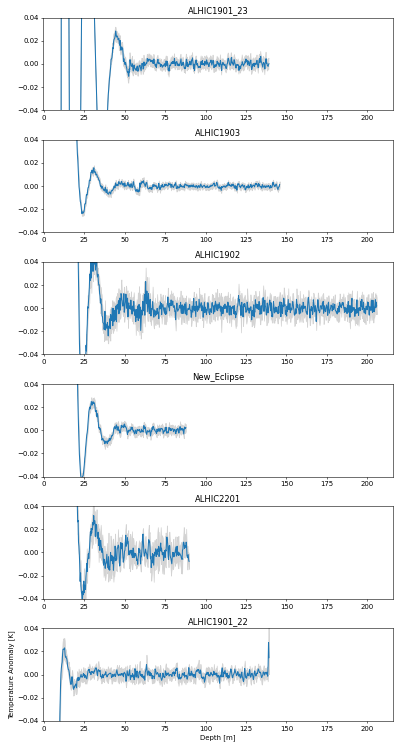

In [188]:
fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(6,1, figsize=[8,15])
ax_list = [ax1, ax2, ax3, ax4, ax5, ax6]
top_of_boreholes = [170.6, 164, 104, 222, 220, 170.6]
for i,ax,x_corr in zip(data,ax_list,top_of_boreholes):
    x = calc_dict[i][0]-x_corr
    mean = calc_dict[i][1]
    ci05 = calc_dict[i][4]
    ci95 = calc_dict[i][3]
    std = calc_dict[i][2]
    ax.fill_between(x, ci05, ci95,color='lightgrey')
    ax.plot(x, mean)
    #ax.plot(x, std)
    ax.set_title(i)
    ax.set_ylim([-0.04,0.04])
plt.xlabel('Depth [m]')
plt.ylabel('Temperature Anomaly [K]')
ax1.get_shared_x_axes().join(ax1, ax2, ax3, ax4, ax5, ax6)
plt.tight_layout()

<IPython.core.display.Javascript object>


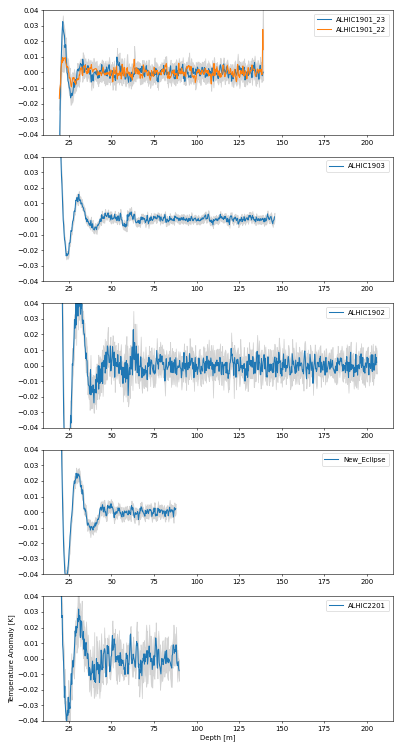

In [171]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5,1, figsize=[8,15])
ax_list = [ax1, ax2, ax3, ax4, ax5, ax1]
top_of_boreholes = [170.6, 164, 104, 222, 220, 170.6]
for i,ax,x_corr in zip(data,ax_list,top_of_boreholes):
    x = calc_dict[i][0]-x_corr
    mean = calc_dict[i][1]
    ci05 = calc_dict[i][4]
    ci95 = calc_dict[i][3]
    std = calc_dict[i][2]
    ax.fill_between(x, ci05, ci95,color='lightgrey')
    ax.plot(x, mean, label=i)
    #ax.plot(x, std)
    ax.set_ylim([-0.04,0.04])
    ax.legend()
plt.xlabel('Depth [m]')
plt.ylabel('Temperature Anomaly [K]')
ax1.get_shared_x_axes().join(ax1, ax2, ax3, ax4, ax5)
plt.tight_layout()

<IPython.core.display.Javascript object>


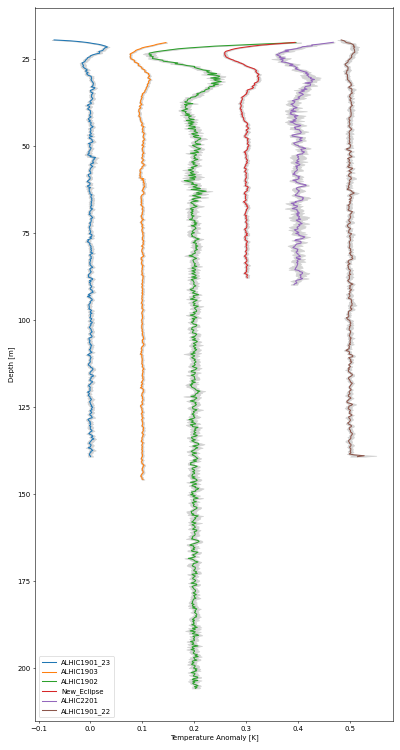

In [186]:
fig, ax = plt.subplots(figsize=[8,15])
top_of_boreholes = [170.6, 164, 104, 222, 220, 170.6]
for j,(i,x_corr) in enumerate(zip(data,top_of_boreholes)):
    x = calc_dict[i][0]-x_corr
    mean = calc_dict[i][1]
    ci05 = calc_dict[i][4]
    ci95 = calc_dict[i][3]
    std = calc_dict[i][2]
    ax.fill_betweenx(x, ci05+j/10, ci95+j/10,color='lightgrey')
    ax.plot(mean+j/10, x, label=i)
    #ax.plot(x, std)
#     ax.set_xlim([-0.04,0.04])
    ax.legend()
plt.ylabel('Depth [m]')
plt.xlabel('Temperature Anomaly [K]')
#ax.get_shared_x_axes().join(ax1, ax2, ax3, ax4, ax5)
plt.gca().invert_yaxis()
plt.tight_layout()

### Plotting the raw data so we can investigate the cable

In [104]:
### Plot the raw data, maybe there is something we can glean from this? ###


raw_dict = {}
mean_stokes_dict = {}
grad_stokes_dict = {}
for name in data:
    borehole_data = data[name]

    st_arr = np.zeros((len(borehole_data), len(borehole_data[0].st)))
    ast_arr = np.zeros((len(borehole_data), len(borehole_data[0].ast)))
    rst_arr = np.zeros((len(borehole_data), len(borehole_data[0].rst)))
    rast_arr = np.zeros((len(borehole_data), len(borehole_data[0].rast)))
    
    tmpw_mc_var_arr = np.zeros((len(borehole_data), len(borehole_data[0].tmpw_mc_var)))
    tmpw_var_arr = np.zeros((len(borehole_data), len(borehole_data[0].tmpw_mc_var)))
    for j in range(int(st_arr.shape[0])):
        st_arr[j,:] = borehole_data[j].st
        ast_arr[j,:] = borehole_data[j].ast
        rst_arr[j,:] = borehole_data[j].rst
        rast_arr[j,:] = borehole_data[j].rast
    
    mean_st = np.mean(st_arr, axis=0)
    mean_ast = np.mean(ast_arr, axis=0)
    mean_rst = np.mean(rst_arr, axis=0)
    mean_rast = np.mean(rast_arr, axis=0)
    
    grad_st = np.gradient(mean_st)
    grad_ast = np.gradient(mean_ast)
    grad_rst = np.gradient(mean_rst)
    grad_rast = np.gradient(mean_rast)
    
    
    
    
    x = borehole_data[0].x
    raw_dict[name] = x, st_arr, ast_arr, rst_arr, rast_arr
    mean_stokes_dict[name] = x, mean_st, mean_ast, mean_rst, mean_rast
    grad_stokes_dict[name] = x, grad_st, grad_ast, grad_rst, grad_rast

<IPython.core.display.Javascript object>


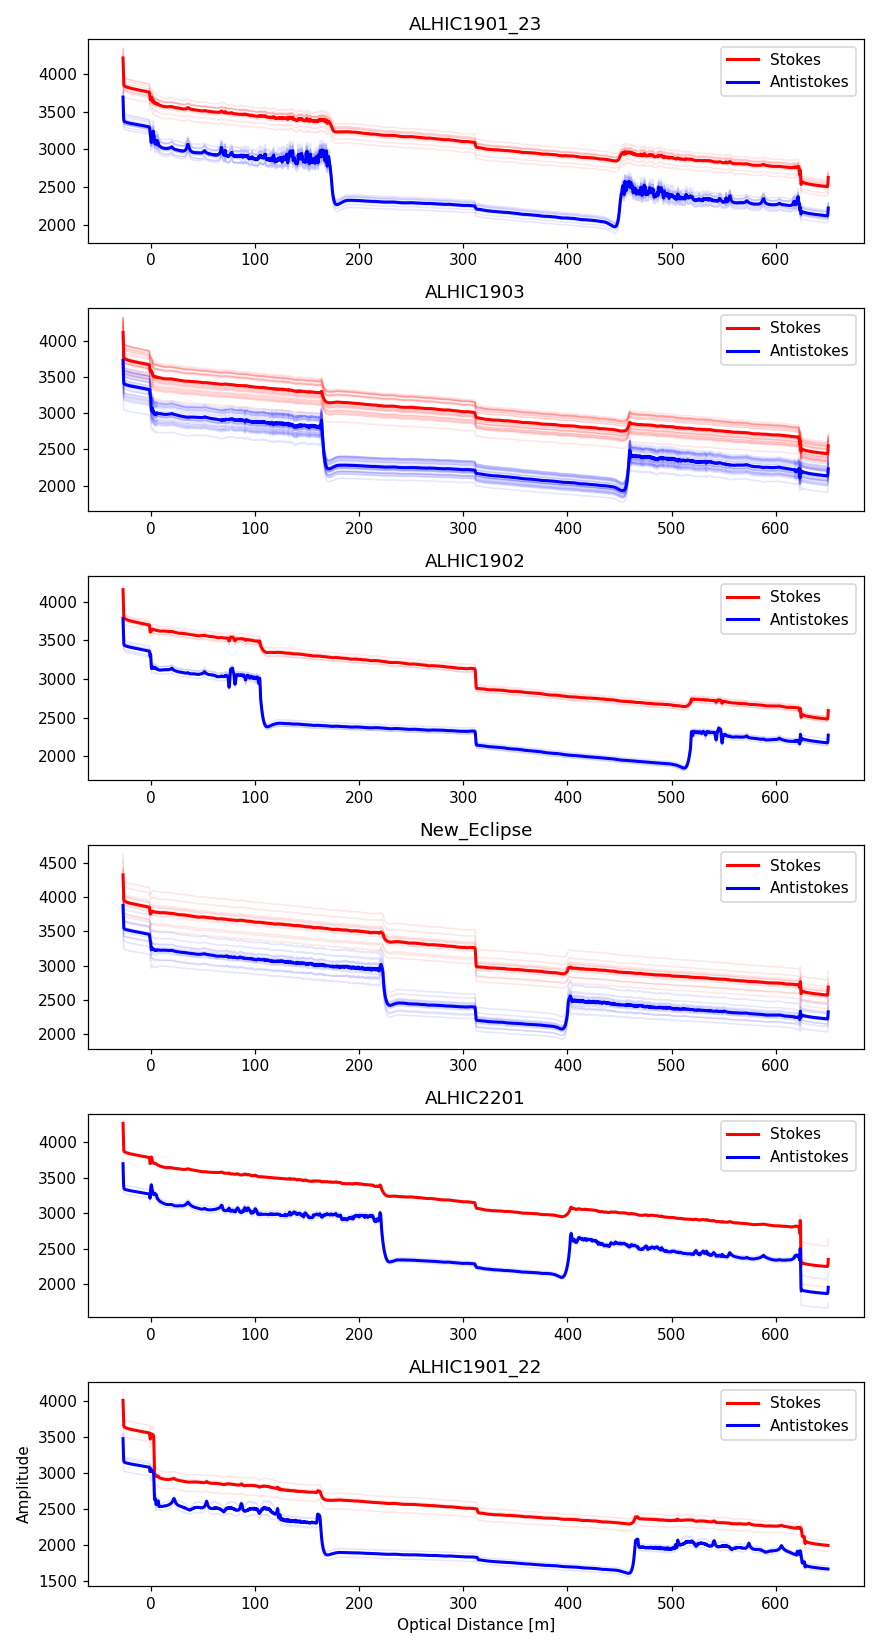

In [109]:
fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(6,1, figsize=[8,15])
ax_list = [ax1, ax2, ax3, ax4, ax5, ax6]
for i,ax in zip(data,ax_list):
    x = raw_dict[i][0]
    st_arr = raw_dict[i][1].T
    ast_arr = raw_dict[i][2].T
    rst_arr = raw_dict[i][3].T
    rast_arr = raw_dict[i][4].T
    
    mean_st = mean_stokes_dict[i][1]
    mean_ast = mean_stokes_dict[i][2]
    mean_rst = mean_stokes_dict[i][3]
    mean_rast = mean_stokes_dict[i][4]
    
    grad_st = grad_stokes_dict[i][1]
    grad_ast = grad_stokes_dict[i][2]
    grad_rst = grad_stokes_dict[i][3]
    grad_rast = grad_stokes_dict[i][4]
    
    ax.plot(x, st_arr, color='red',alpha=0.1, lw=1)
    ax.plot(x, ast_arr, color='blue',alpha=0.1, lw=1)
    ax.plot(x, mean_st, color='red', lw=2, label='Stokes')
    ax.plot(x, mean_ast, color='blue', lw=2, label='Antistokes')
    ax.set_title(i)
    ax.legend()

plt.xlabel('Optical Distance [m]')
plt.ylabel('Amplitude')
ax1.get_shared_x_axes().join(ax1, ax2, ax3, ax4, ax5, ax6)
plt.tight_layout()

<IPython.core.display.Javascript object>


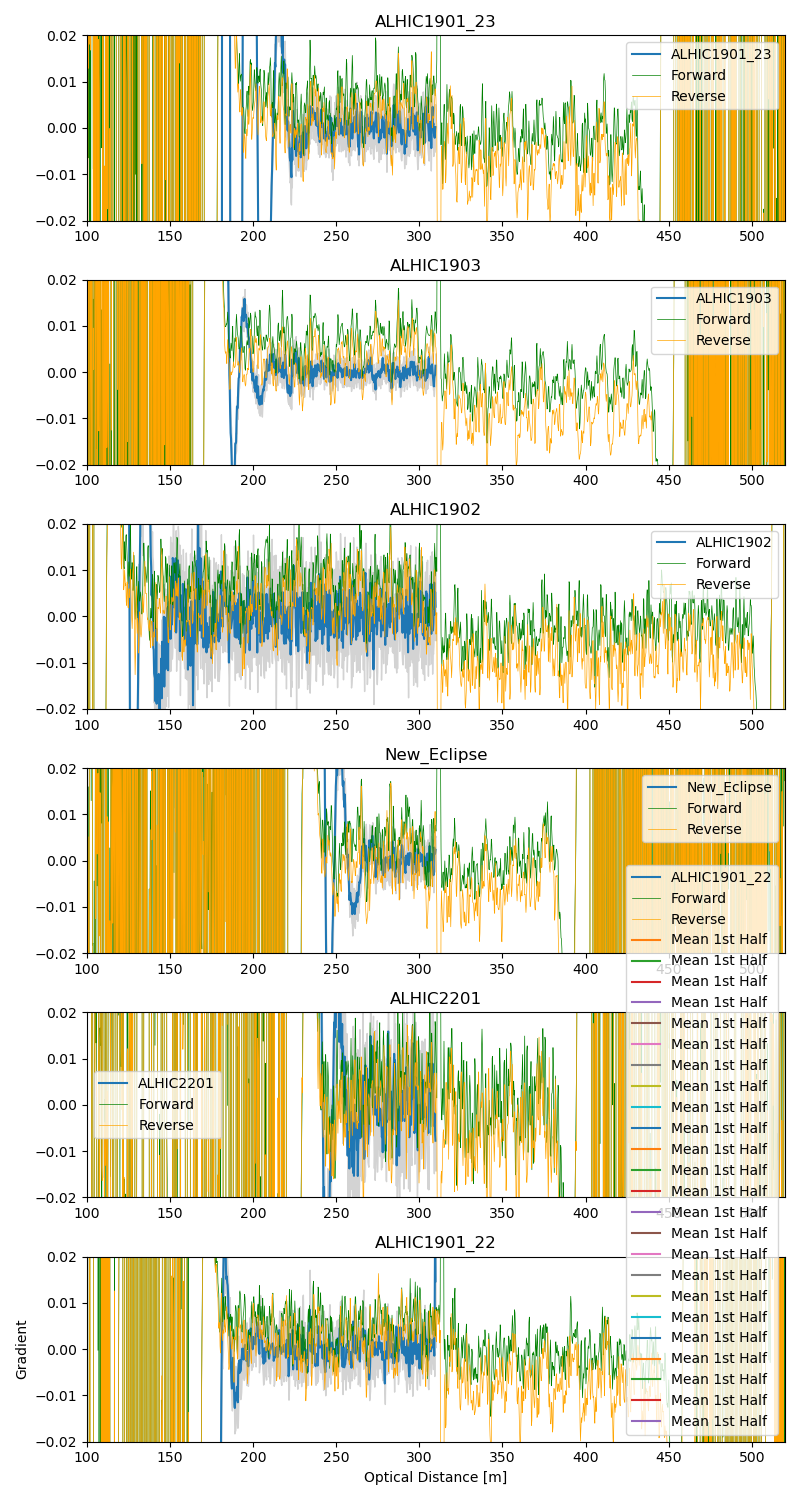

In [190]:
fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(6,1, figsize=[8,15])
ax_list = [ax1, ax2, ax3, ax4, ax5, ax6]
top_of_boreholes = [168, 164, 104, 222, 218, 160]
depth_of_boreholes = [143, 160, 200, 95, 92, 154]
for i,ax,left,right in zip(data,ax_list, top_of_boreholes, depth_of_boreholes):
    x = raw_dict[i][0]
    st_arr = raw_dict[i][1].T
    ast_arr = raw_dict[i][2].T
    rst_arr = raw_dict[i][3].T
    rast_arr = raw_dict[i][4].T
    
    mean_st = mean_stokes_dict[i][1]
    mean_ast = mean_stokes_dict[i][2]
    mean_rst = mean_stokes_dict[i][3]
    mean_rast = mean_stokes_dict[i][4]
    
    grad_st = grad_stokes_dict[i][1]
    grad_ast = grad_stokes_dict[i][2]
    grad_rst = grad_stokes_dict[i][3]
    grad_rast = grad_stokes_dict[i][4]
    x_temp = calc_dict[i][0]
    mean = calc_dict[i][1]
    ci05 = calc_dict[i][4]
    ci95 = calc_dict[i][3]
    std = calc_dict[i][2]
    ax.fill_between(x_temp, ci05, ci95,color='lightgrey')
    
#     ax.plot(x, grad_st, color='red', lw=1, label='Stokes')
#     ax.plot(x, grad_ast, color='blue', lw=1, label='Antistokes')
    ax.plot(x_temp, mean, label=i)
    ax.plot(x, (grad_ast-grad_st)*.05, color='green', lw=.5, label='Forward')
    ax.plot(x, (grad_rast-grad_rst)*.05, color='orange', lw=.5, label='Reverse')
    ax.set_ylim([-0.02,0.02])
    ax.set_xlim([100,520])
    ax.set_title(i)
    ax.legend()

plt.xlabel('Optical Distance [m]')
plt.ylabel('Gradient')
ax1.get_shared_x_axes().join(ax1, ax2, ax3, ax4, ax5, ax6)
plt.tight_layout()

In [189]:
### TODO
# Separate the down going and up going fiber - Do we see the same temperature on either side of U-bend?
# Double check that the ground surface (top of the borehole) is picked accurately (also the seasonal signal picks).
# Make a plot and shift the borehole surface heights are represented (shift to some reference height).
# Investigate the periodic gradients (see the gradient plot I sent in slack).
# Take the gradient of the temperature and see how it correlates to the gradient of the stokes and antistokes.


#### Plot either side of the u-bend separately, do we see the same temperatures?

In [193]:
## Plotting the anomaly for all boreholes ###


below_seasons = [180, 184, 124, 242, 240, 180]
# below_seasons = [170.6, 164, 104, 222, 220]
sos = signal.butter(4, .06, 'hp', fs=4, output='sos')

calc_dict = {}

for name, start in zip(data, below_seasons):
    borehole_data = data[name]

    borehole_arr = np.zeros((len(borehole_data[0].sel(x=slice(start,bottom_of_trend)).tmpw.T),
                                     len(borehole_data)*2))
    refl_corr = 2*(bottom_hole - bottom_of_trend) + bottom_of_trend
    top_refl = refl_corr + (bottom_of_trend-start)
    sample_steps = 0.255 #m
    print(borehole_arr.shape)
    for j in range(int(borehole_arr.shape[1]/2)):
        measurement_for = borehole_data[j].sel(x=slice(start,bottom_of_trend)).tmpw.T
        measurement_rev = borehole_data[j].sel(x=slice(refl_corr, top_refl)).tmpw[::-1]
        if len(measurement_rev) != len(measurement_for):
            measurement_rev = borehole_data[j].sel(x=slice(refl_corr, top_refl - sample_steps)).tmpw[::-1]
        detrend_for = scipy.signal.detrend(measurement_for, type='linear', bp=0, overwrite_data=False)
        detrend_rev = scipy.signal.detrend(measurement_rev, type='linear', bp=0, overwrite_data=False)

        filtered_for = signal.sosfilt(sos, detrend_for)
        filtered_rev = signal.sosfilt(sos, detrend_rev)

        borehole_arr[:,j] = filtered_for
        borehole_arr[:,int(borehole_arr.shape[1]/2)+j] = filtered_rev
    
    mean_1half = np.mean(borehole_arr[:,:int(borehole_arr.shape[1]/2)], axis=1)
    mean_2half = np.mean(borehole_arr[:,int(borehole_arr.shape[1]/2):], axis=1)
#     ci95, ci05 = st.t.interval(alpha=0.95, df=len(borehole_arr)-1, 
#                   loc=mean, 
#                   scale=st.sem(borehole_arr, axis=1)) 
    arr_std_1half = np.std(borehole_arr[:,:int(borehole_arr.shape[1]/2)],axis=1)
    arr_std_2half = np.std(borehole_arr[:,int(borehole_arr.shape[1]/2):],axis=1)
    print(borehole_arr[:,:int(borehole_arr.shape[1]/2)].shape)
    x = borehole_data[0].sel(x=slice(start,bottom_of_trend)).x
    calc_dict[name] = x,  mean_1half, mean_2half, arr_std_1half, arr_std_2half

(511, 22)
(511, 11)
(495, 62)
(495, 31)
(731, 12)
(731, 6)
(267, 26)
(267, 13)
(275, 4)
(275, 2)
(511, 6)
(511, 3)


<IPython.core.display.Javascript object>


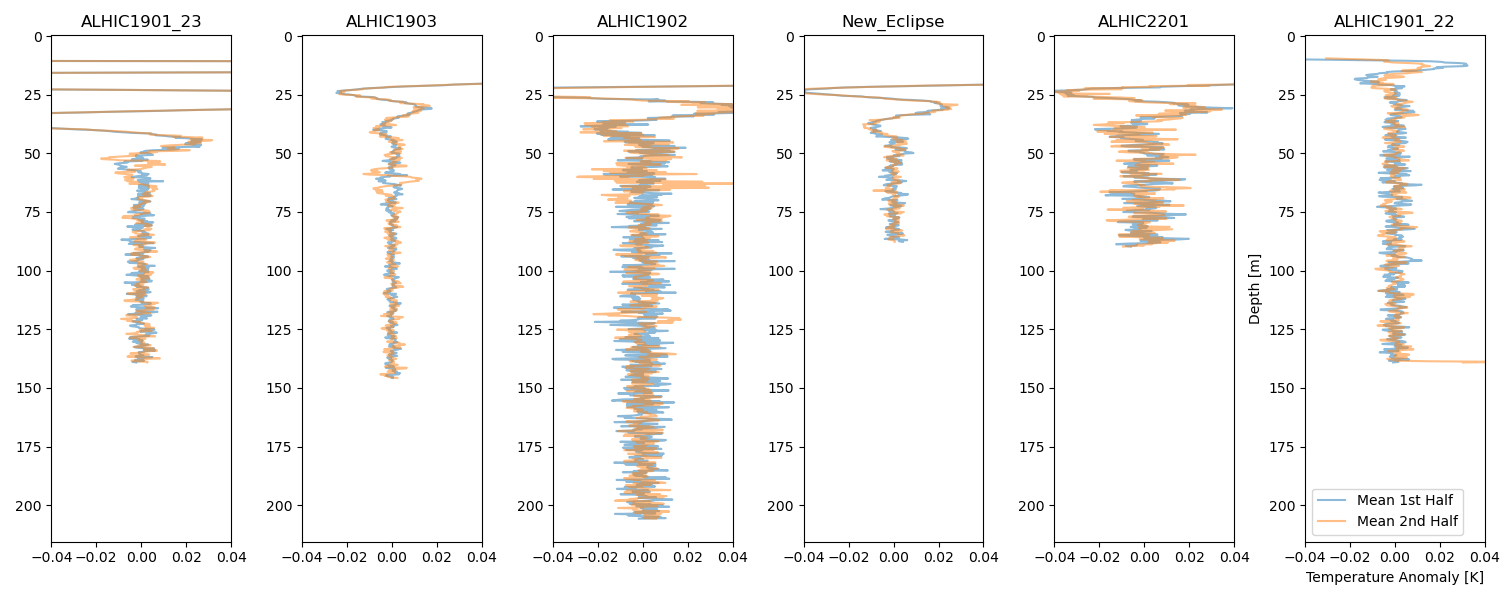

In [205]:
fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(1,6, figsize=[15,6])
ax_list = [ax1, ax2, ax3, ax4, ax5, ax6]
top_of_boreholes = [170.6, 164, 104, 222, 220, 170.6]
for j,(i,x_corr, ax) in enumerate(zip(data,top_of_boreholes,ax_list)):
    x = calc_dict[i][0]-x_corr
    mean1 = calc_dict[i][1]
    mean2 = calc_dict[i][2]
#     ci05 = calc_dict[i][4]
#     ci95 = calc_dict[i][3]

    #ax.fill_betweenx(x, ci05+j/10, ci95+j/10,color='lightgrey')
    ax.plot(mean1, x, label='Mean 1st Half',alpha=0.5)
    ax.plot(mean2, x, label='Mean 2nd Half',alpha=0.5)
    ax.set_title(i)
    #ax.plot(x, std)
    ax.set_xlim([-0.04,0.04])
plt.ylabel('Depth [m]')
plt.xlabel('Temperature Anomaly [K]')
plt.legend()
ax.get_shared_y_axes().join(ax1, ax2, ax3, ax4, ax5, ax6)
plt.gca().invert_yaxis()
plt.tight_layout()

#### Redo the picking of the top of the borehole and the seasonal signal.

In [207]:
## we will take the top of the borehole to be the apex of the curve going to the cool trend.

In [208]:
### 1901 borehole geometry ###
top_of_borehole = 170.6 #m
top_of_trend = 190 #m
bottom_of_trend = 310 #m, this is the last depth measurement we want to keep
below_noise = 190 #m, this shoiuld be below the noisy part of the data (maybe due to cable strain?
bottom_hole = 311.9 #m, this is the bottom of the hole

refl_corr = 2*(bottom_hole - bottom_of_trend) + bottom_of_trend
top_refl = refl_corr + (bottom_of_trend-below_noise)
sample_steps = 0.255 #m

In [251]:
## Peak finding from scipy
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks



## Plotting the anomaly for all boreholes ###


below_seasons = [180, 184, 124, 242, 240, 180]
# below_seasons = [170.6, 164, 104, 222, 220]
sos = signal.butter(4, .06, 'hp', fs=4, output='sos')

peaks_dict = {}

for name, start in zip(data, below_seasons):
    borehole_data = data[name]

    borehole_arr = np.zeros((len(borehole_data[0].tmpw.T),
                                     len(borehole_data)*2))
    for j in range(int(borehole_arr.shape[1]/2)):
        measurement_for = borehole_data[j].tmpw.T
        measurement_rev = borehole_data[j].tmpw[::-1]
        borehole_arr[:,j] = measurement_for
        borehole_arr[:,int(borehole_arr.shape[1]/2)+j] = measurement_rev
    
    
    peaks_arr = []
    for p in borehole_arr.T:
        peaks, _ = find_peaks(p, distance=350, width=3, prominence=5)
        peaks_arr.append(peaks)
    x = borehole_data[0].x
    peaks_dict[name] = x, peaks_arr

<IPython.core.display.Javascript object>


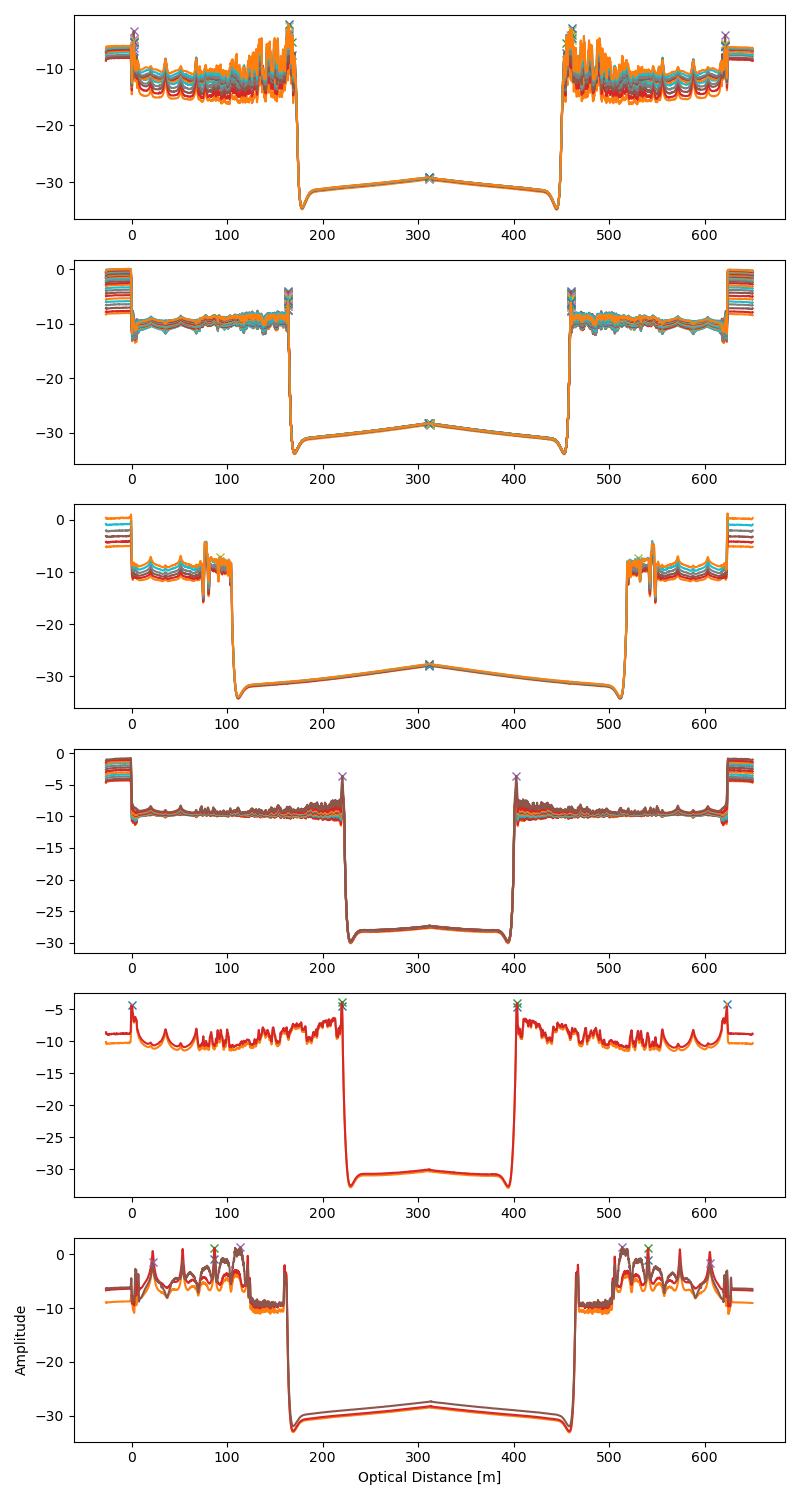

In [252]:
fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(6,1, figsize=[8,15])
ax_list = [ax1, ax2, ax3, ax4, ax5, ax6]
for i,ax in zip(data,ax_list):
    x = peaks_dict[i][0]
    peaks = peaks_dict[i][1]
    for temps, p in zip(data[i], peaks):
        ax.plot(x[p], temps.tmpw.values[p], 'x')
        ax.plot(x, temps.tmpw.values)
plt.xlabel('Optical Distance [m]')
plt.ylabel('Amplitude')
ax1.get_shared_x_axes().join(ax1, ax2, ax3, ax4, ax5, ax6)
plt.tight_layout()

